# 03 Redeem_filter2_benchmark
---

**Author:** Chen Weng

**Date:** August 20, 2024



---

# Load packages and define function

In [4]:
library(data.table)
library(dplyr)
library(redeemR)
library(ggplot2)
library(gridExtra)
library(ggsci)
library(ggvenn)
get_mut_per_cell <-function(redeemR = redeemR.1, 
                            name_for_redeem = sample1, cells, blacklist){
    homo <- subset(redeemR@V.fitered, HomoTag=="Homo")$Variants
    ## filter
    Cts.Mtx.bi.filtered <- redeemR@Cts.Mtx.bi[,!colnames(redeemR@Cts.Mtx.bi) %in% convert_variant(c(homo, blacklist))] %>% as.matrix
    ## make sure each cell has at least one mutation that is shared with other cells
    Cts.Mtx.bi.filtered<-Cts.Mtx.bi.filtered[rowSums(Cts.Mtx.bi.filtered)>=1,colSums(Cts.Mtx.bi.filtered)>=2]

    ## Get the cells overlap between Seurat and redeem
    redeem_cells_in_seurat <- intersect(cells, row.names(Cts.Mtx.bi.filtered)) 

    overlap_ratio_1plus<-length(redeem_cells_in_seurat)/length(cells)

    ## Process the matrix only for overlapped cells
    Cts.Mtx.bi.filtered.inseurat<-Cts.Mtx.bi.filtered[redeem_cells_in_seurat,]
    Cts.Mtx.bi.filtered.inseurat <- Cts.Mtx.bi.filtered.inseurat[,colSums(Cts.Mtx.bi.filtered.inseurat)>=2]

    ## Count the cells with different mutation numbers
    N0 <- setdiff(cells, redeem_cells_in_seurat) %>% length ## count number of cells in seurat but no mutation detected in redeem
    N1 <- sum(rowSums(Cts.Mtx.bi.filtered.inseurat)==1) 
    N2 <- sum(rowSums(Cts.Mtx.bi.filtered.inseurat)==2) 
    N3plus <- sum(rowSums(Cts.Mtx.bi.filtered.inseurat)>=3) 
    # N4 <- sum(rowSums(Cts.Mtx.bi.filtered.inseurat)==4) 
    # N5plus <- sum(rowSums(Cts.Mtx.bi.filtered.inseurat)>=5) 
    # df<- data.frame(sample=name_for_redeem, N= c(N0, N1, N2, N3, N4, N5plus), cat=c("0","1","2","3","4",">=5"))
    df<- data.frame(sample=name_for_redeem, N= c(N0, N1, N2, N3plus), cat=c("0","1","2",">=3"))

    return(df)
}

get_transversion_ratio <- function(redeem, homosets=c(blacklist, redeemR.2@HomoVariants)){
    redeem@V.fitered <- redeem@V.fitered %>% mutate(changes=add_changes(Variants)) %>% mutate(types=add_types(changes))
    redeem@raw.fragment.uniqV<-redeem@raw.fragment.uniqV %>% mutate(changes=add_changes(variant)) %>% mutate(types=add_types(changes)) 
    raw.fragment.uniqV_allhetero <- subset(redeem@raw.fragment.uniqV, !variant %in% homosets)
    raw.fragment.uniqV_1mol<-subset(redeem@raw.fragment.uniqV, Freq==1 & !variant %in% homosets)
    raw.fragment.uniqV_2mol<-subset(redeem@raw.fragment.uniqV, Freq==2 & !variant %in% homosets)
    raw.fragment.uniqV_3molplus<-subset(redeem@raw.fragment.uniqV, Freq>=3 & !variant %in% homosets)
    transversion_rate<-c(freq_all=sum(raw.fragment.uniqV_allhetero$types=="transversion")/nrow(raw.fragment.uniqV_allhetero),
                         freq_1mol=sum(raw.fragment.uniqV_1mol$types=="transversion")/nrow(raw.fragment.uniqV_1mol),
                         freq_2mol=sum(raw.fragment.uniqV_2mol$types=="transversion")/nrow(raw.fragment.uniqV_2mol),
                         freq_3molplus=sum(raw.fragment.uniqV_3molplus$types=="transversion")/nrow(raw.fragment.uniqV_3molplus), random=0.67)
                         
    return(transversion_rate)
}

## Input for testing 
## Ssample name to extract redeem
# sample1 = "v1.young1_HSC"
# sample2 = "trim5_binom.young1_HSC"
# blacklist = c("310_T_C","72_T_C", "10810_T_C","309_C_T")
# seuratobj =  young1.seurat
# sample = "DN4_HSC"

run_one_for_redeem <- function(sample1 = "v1.young1_HSC",
                               sample2 = "trim5_binom.young1_HSC",
                              blacklist = c("310_T_C","72_T_C", "10810_T_C","309_C_T"),
                              seuratobj =  young1.seurat,
                              sample = "DN4_HSC",
                              dataset){
    ## Get cell name from seurat
    cell_names<- subset(seuratobj@meta.data, Sample==sample) %>% row.names  %>% Translate_simple_RNA2ATAC(., PostFix = F) %>% 
    as.character()

    ## Get redeem
    redeemR.1<-dataset[[sample1]]$redeemR
    redeemR.2<-dataset[[sample2]]$redeemR

    ## handle p1
    transversion_datatoplot <- data.frame(ratio=get_transversion_ratio(redeemR.2, homosets=c(blacklist, redeemR.2@HomoVariants)))
    transversion_datatoplot$group <- row.names(transversion_datatoplot)
    transversion_datatoplot$group<-factor(transversion_datatoplot$group, levels=c("random","freq_all","freq_1mol","freq_2mol","freq_3molplus"))
    p1<-ggplot(transversion_datatoplot)+aes(group, ratio, fill=group)+geom_bar(stat="identity")+theme_cw1()+scale_fill_jco()

    ## handle p2
    p2<-subset(redeemR.2@V.fitered,HomoTag=="Hetero" & !Variants %in% blacklist) %>% mutate(changes=add_changes(Variants)) %>% mutate(types=add_types(changes)) %>% 
    ggplot() + aes(log2(CellN), log2(PositiveMean_cts), color=types) +geom_point()+scale_color_brewer(palette="Set1")+theme_cw1()

    ## handle p3 
    p3 <-subset(redeemR.2@raw.fragment.uniqV, !variant %in% c(redeemR.2@HomoVariants,blacklist)) %>% 
    ggplot()+aes(rel_position)+geom_histogram(binwidth=0.02, fill="white", color="black")+theme_cw1()

    ## handle p4
    data_for_p4<-data.frame(samples=c(sample1, sample2),total_mut=c(
    nrow(subset(redeemR.1@V.fitered,HomoTag=="Hetero" & !Variants %in% blacklist)),
    nrow(subset(redeemR.2@V.fitered,HomoTag=="Hetero" & !Variants %in% blacklist))
    ))
    data_for_p4$samples <-factor(data_for_p4$samples, levels= c(sample1, sample2))
    p4<-ggplot(data_for_p4)+aes(samples,total_mut, fill=samples)+geom_bar(stat="identity")+theme_cw1()+scale_x_discrete(labels = c("filter-1","filter-2"))

    ## Process for p5
    mut_per_cell_datatoplot<-rbind(get_mut_per_cell(redeemR.1, sample1, cells=cell_names, blacklist),get_mut_per_cell(redeemR.2, sample2, cells= cell_names, blacklist))
    mut_per_cell_datatoplot$new_mol_group <- mut_per_cell_datatoplot$cat
    mut_per_cell_datatoplot$new_mol_group[which(mut_per_cell_datatoplot$new_mol_group!="0")] <- "1"
    mut_per_cell_datatoplot$new_mol_group <- factor(mut_per_cell_datatoplot$new_mol_group, levels=c("0", "1"))
    mut_per_cell_datatoplot$cat <- factor(mut_per_cell_datatoplot$cat, levels=c("0","1","2",">=3"))
    mut_per_cell_datatoplot$sample<-factor(mut_per_cell_datatoplot$sample, levels=c(sample1, sample2))
    p5<- ggplot(mut_per_cell_datatoplot)+aes(sample, N, fill= new_mol_group)+geom_bar(stat="identity")+
    scale_fill_manual(values = c("0" = "grey", "1" = "blue"))+theme_cw1()+scale_x_discrete(labels = c("filter-1","filter-2"))
    grid.arrange(p1,p2,p3,p4,p5, nrow=1, top=sample)   
}

read_mgatk_stat <- function(WD, sample, chem){
    mgatk_df_in <- fread(paste0(WD,sample,"/",chem, "/mgatk_out/final/mgatk.variant_stats.tsv.gz"))
    mgatk_df_in$variant <- name_change_mgatk_v1(mgatk_df_in$variant)
    mgatk_df <- mgatk_df_in %>% filter(strand_correlation > 0.65 & n_cells_conf_detected >= 3 & (log10(vmr) > -2) & mean < 0.8)
    return(mgatk_df)
}

read_mgatk_stat_all <- function(WD, sample, chem){
    mgatk_df_in <- fread(paste0(WD,sample,"/",chem, "/mgatk_out/final/mgatk.variant_stats.tsv.gz"))
    mgatk_df_in$variant <- name_change_mgatk_v1(mgatk_df_in$variant)
    return(mgatk_df_in)
}

read_mgatk_mtx <- function(WD, sample, chem){
    mgatk_df_in <- fread(paste0(WD,sample,"/",chem, "/mgatk_out/final/mgatk.cell_heteroplasmic_df.tsv.gz")) %>% as.data.frame()
    colnames(mgatk_df_in)<- name_change_mgatk_v1(colnames(mgatk_df_in))
    row.names(mgatk_df_in)<-mgatk_df_in[,1]
    mgatk_df_in <- mgatk_df_in[,-1]
    return(mgatk_df_in)
}

## change mgatk matrix colnames into redeem style
name_change_mgatk_v1 <- function(variants){
variants <- gsub("([0-9]+)([A-Z])>([A-Z])", "\\1_\\2_\\3", variants)
return(variants)    
}    

## Change mgatk stat name into redeem style
name_change_mgatk_v2 <- function(variants){
variants <- gsub("^X([0-9]+)([A-Z])\\.([A-Z])$", "\\1_\\2_\\3", variants)
return(variants)    
}    

get_mut_list <- function(redeem, mgatk_tenx_stat, mgatk_redeem_stat, blacklist ){
    ## Get homoplasmy mutations
    homo <- redeem@HomoVariants
    muts_redeem<- subset(redeem@V.fitered, HomoTag == "Hetero" &  !Variants %in% blacklist) %>% pull(Variants) 
    muts_mgatk_tenx <-setdiff(mgatk_tenx_stat$variant, c(homo, blacklist))
    mut_mgatk_redeem <-setdiff(mgatk_redeem_stat$variant, c(homo, blacklist))
    mut_groups<- list(full_redeem=muts_redeem, mgatk_redeem= muts_mgatk_tenx,mgatk_10x=mut_mgatk_redeem)
    return(list(mut_groups))
}

count_mut_number <- function(mut_list=cross_method_mut_list, methods = c("full_redeem","mgatk_redeem","mgatk_10x", "mquade_redeem","mquade_tenx")){
    ## The input methods should match the code in get_mut_list line "mut_groups<- list(...)
    total_mut_summary <- c()
    for (i in 1: length(mut_list)){
        total_mut <- c()
        for (j in 1:length(methods)){
            mut_n<- length(mut_list[[i]][[j]])
            total_mut <- c(total_mut, mut_n)
        }
        df<-data.frame(sample=names(mut_list)[i],total_mut=total_mut, method=methods)
        total_mut_summary<- rbind(total_mut_summary,df)
}
    return(total_mut_summary)
}

## functin to plot 2-way venndiagram
## a, b, c are the index in the list to take
plotvenn <- function(mut_list, a, b, c, names= c("full_redeem","mgatk")){
    ps<-list()
    for (i in 1: length(mut_list)){
    s1 <- mut_list[[i]][[a]]
    s2 <- union(mut_list[[i]][[b]], mut_list[[i]][[c]])
    mutation_list <- list(s1, s2)
    names(mutation_list) <- names
    p<-ggvenn(mutation_list)+ggtitle(names(mut_list)[i])
    ps<-c(ps, list(p))
}
    return(ps)
}

## functin to plot 3-way venndiagram
## a, b, c are the index in the list to take
plotvenn3 <- function(mut_list, a, b, c, names= c("full_redeem","mgatk_redeem", "mgatk_tenx")){
    ps<-list()
    for (i in 1: length(mut_list)){
    s1 <- mut_list[[i]][[a]]
    s2 <- union(mut_list[[i]][[b]], 
    s3 <- mut_list[[i]][[c]])
    mutation_list <- list(s1, s2, s3)
    names(mutation_list) <- names
    p<-ggvenn(mutation_list)+ggtitle(names(mut_list)[i])
    ps<-c(ps, list(p))
}
    return(ps)
}


In [5]:
getwd()

[1] "/lab/solexa_weissman/cweng/Projects/Collaborator/Caleb/github_redeem_plus/notebooks/notebook_share"

# Compare QC for filter1 and filter2

## Load data

In [6]:
redeemv_final <- "./data/redeemV_final"
out <- "./output/"
prefix <- "prepare_redeemr_"
con <- c("v1.","trim5_binom.")
samples<-c("young1_BMMC","young1_HPC", "young1_HSC",
           "young2_BMMC","young2_HPC", "young2_HSC")
suffix <- ".rds"
names<-c()
dataset<-list()
for (i in 1:2){
    for (j in 1:length(samples)){
        name<-paste(con[i],samples[j],sep="")
        names <- c(names,name)
        data <- readRDS(paste0(out,prefix,con[i],samples[j],suffix))
        dataset <- c(dataset,list(data))
    }
}
names(dataset) <- names
dir <- "./data/"
young1.seurat <- readRDS(paste0(dir, "Young1.All.T1.Seurat.RDS"))
young2.seurat <- readRDS(paste0(dir, "Young2.All.Seurat.RDS"))


run_one_for_redeem## QC plot

The following `from` values were not present in `x`: 1, 2

The following `from` values were not present in `x`: 2, 3



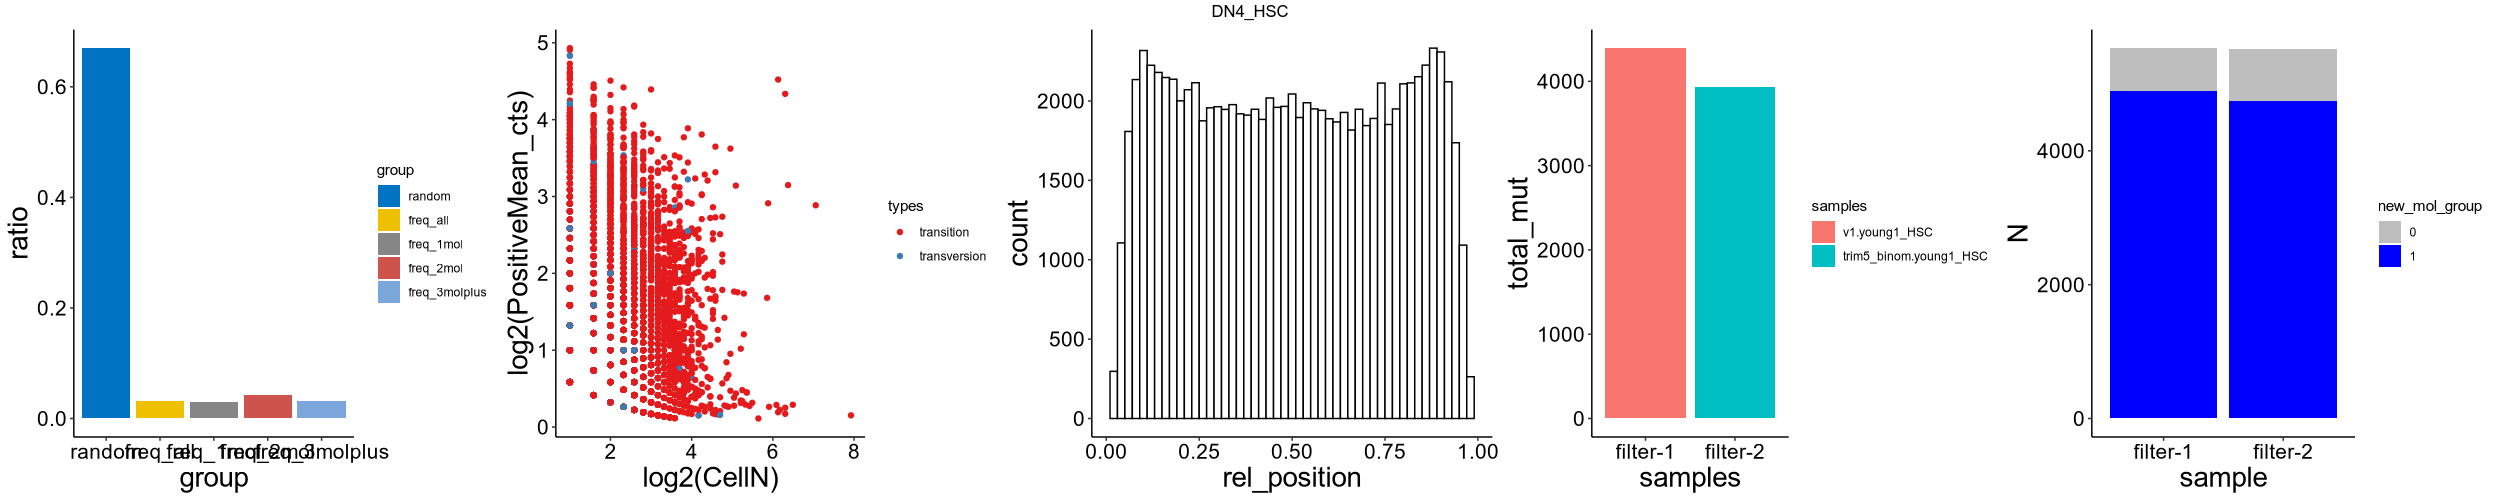

The following `from` values were not present in `x`: 1, 3



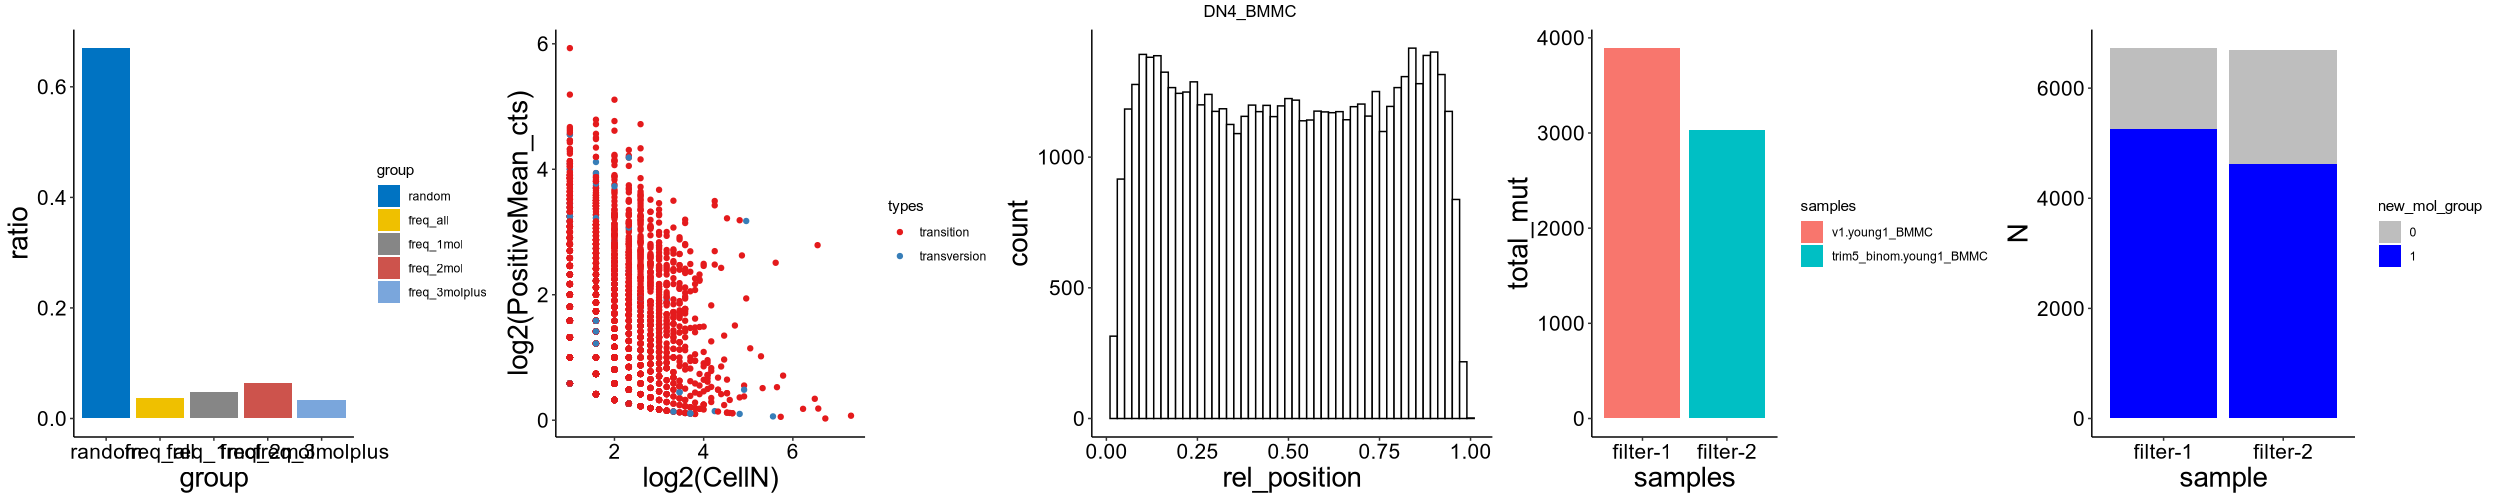

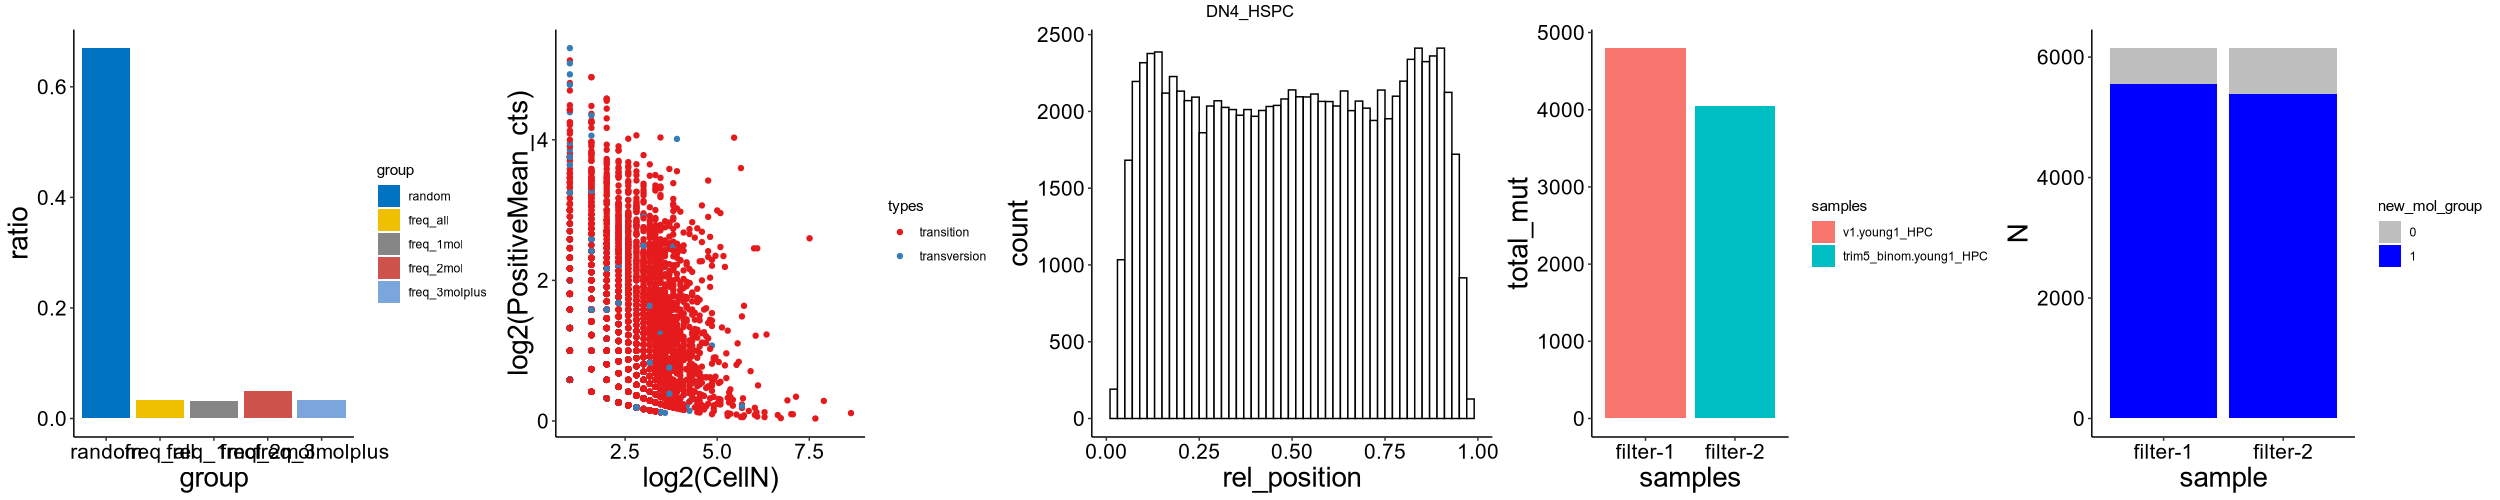

In [29]:
options(repr.plot.width = 25, repr.plot.height = 5, repr.plot.res = 100)
run_one_for_redeem(sample1 = "v1.young1_HSC",
                   sample2 = "trim5_binom.young1_HSC",
                   blacklist = c("310_T_C","72_T_C", "10810_T_C","309_C_T"),
                   seuratobj =  young1.seurat,
                   sample = "DN4_HSC",
                   dataset)
run_one_for_redeem(sample1 = "v1.young1_BMMC",
                   sample2 = "trim5_binom.young1_BMMC",
                   blacklist = c("310_T_C","72_T_C", "10810_T_C","309_C_T"),
                   seuratobj =  young1.seurat,
                   sample = "DN4_BMMC",
                   dataset)
run_one_for_redeem(sample1 = "v1.young1_HPC",
                   sample2 = "trim5_binom.young1_HPC",
                   blacklist = c("310_T_C","72_T_C", "10810_T_C","309_C_T"),
                   seuratobj =  young1.seurat,
                   sample = "DN4_HSPC",
                   dataset)

The following `from` values were not present in `x`: 1, 2

The following `from` values were not present in `x`: 2, 3



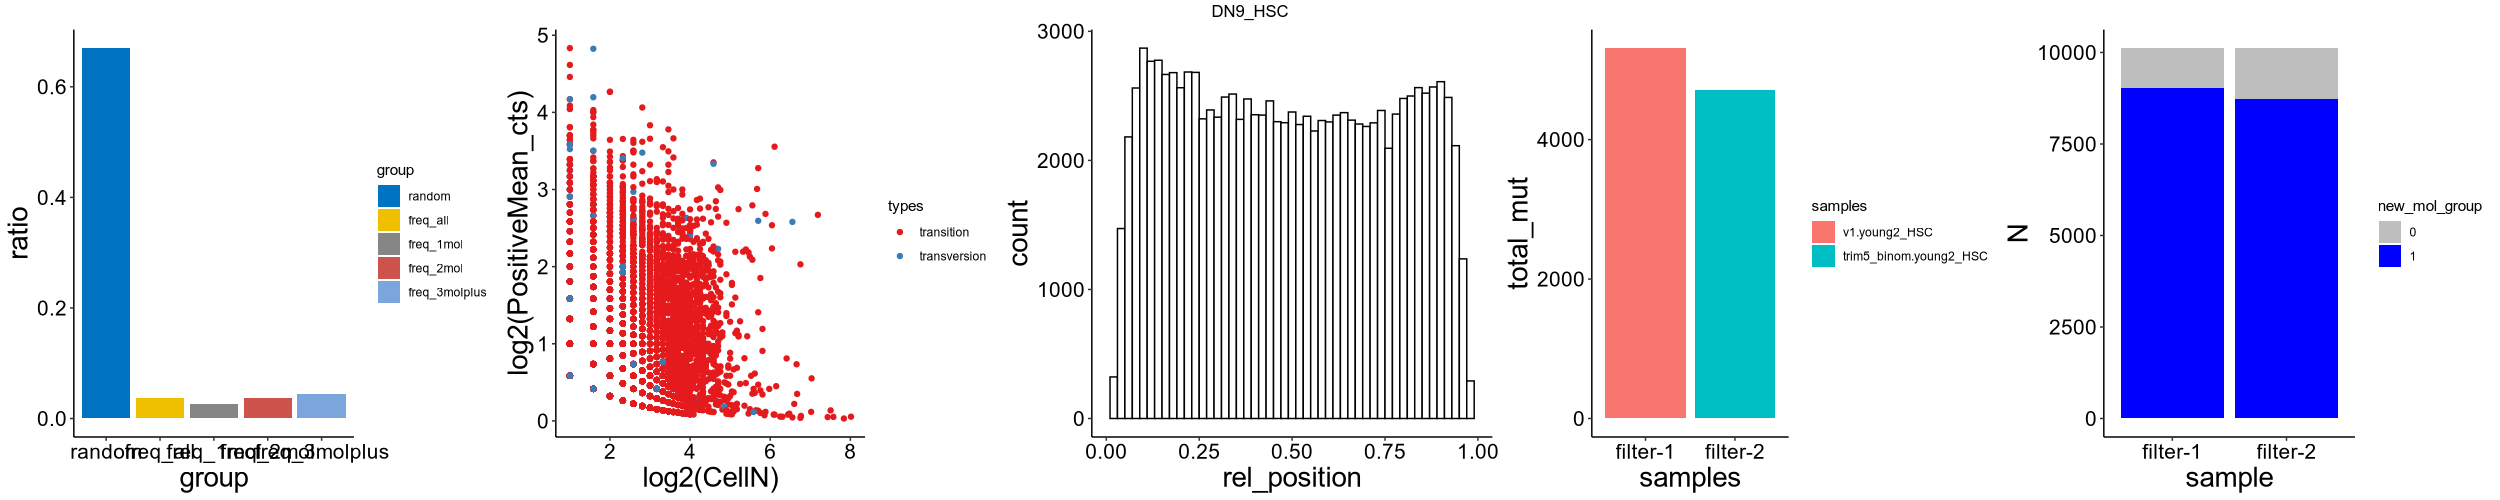

The following `from` values were not present in `x`: 1, 3



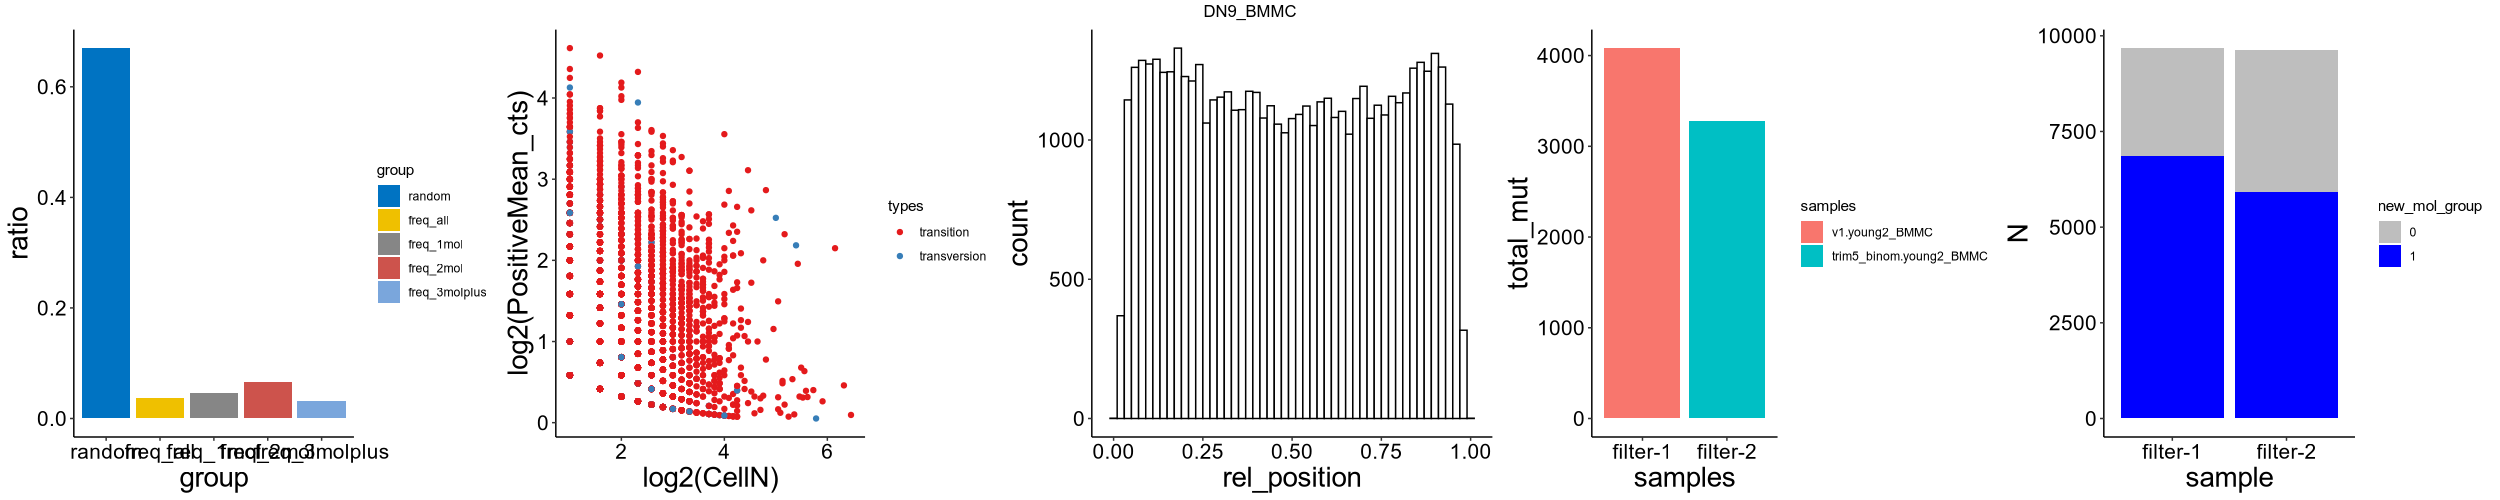

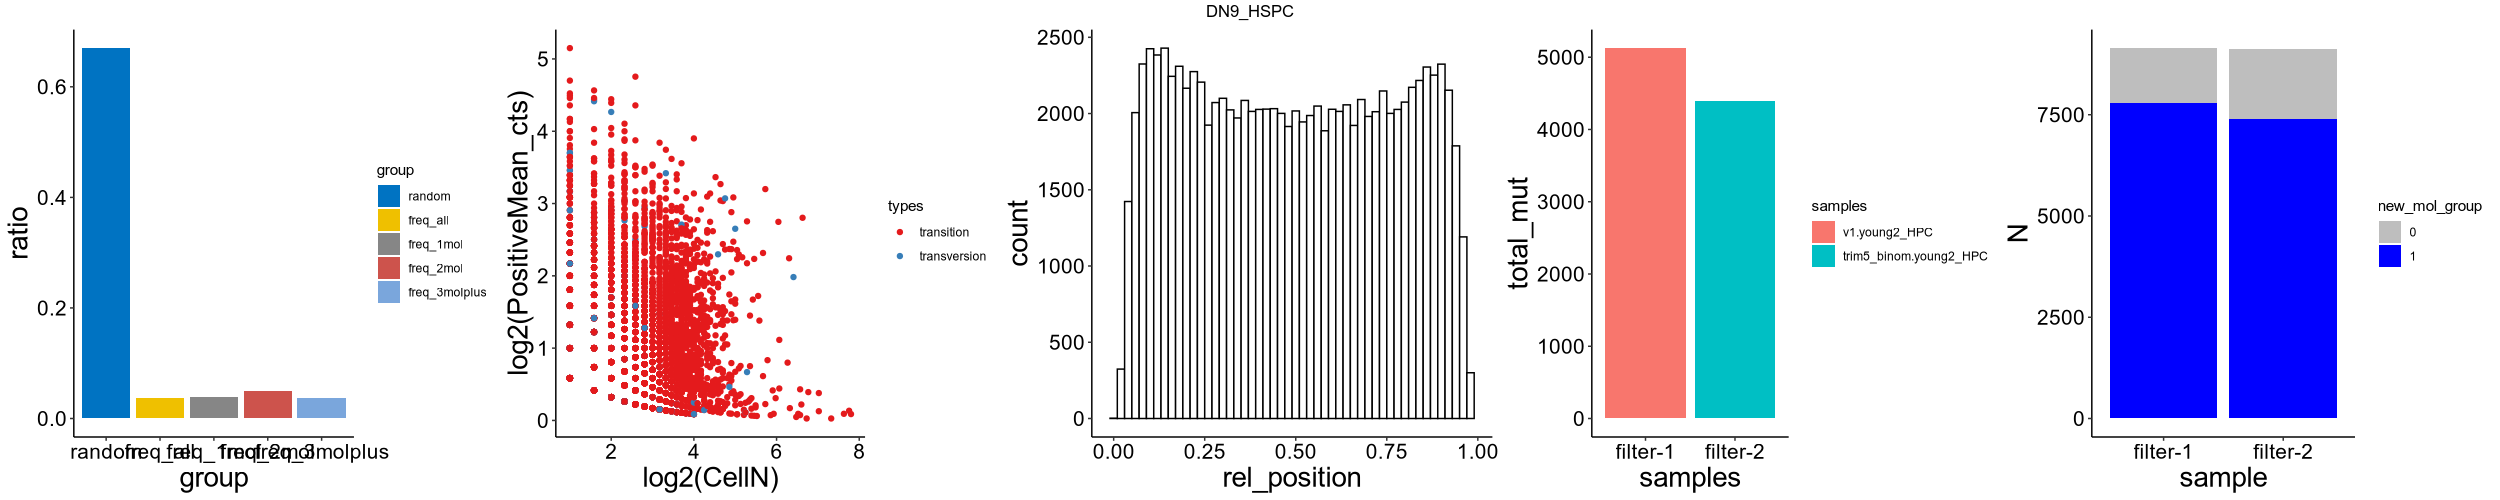

In [30]:
run_one_for_redeem(sample1 = "v1.young2_HSC",
                   sample2 = "trim5_binom.young2_HSC",
                   blacklist = c("310_T_C","72_T_C", "10810_T_C","309_C_T"),
                   seuratobj =  young2.seurat,
                   sample = "DN9_HSC",
                   dataset)
run_one_for_redeem(sample1 = "v1.young2_BMMC",
                   sample2 = "trim5_binom.young2_BMMC",
                   blacklist = c("310_T_C","72_T_C", "10810_T_C","309_C_T"),
                   seuratobj =  young2.seurat,
                   sample = "DN9_BMMC", 
                   dataset)
run_one_for_redeem(sample1 = "v1.young2_HPC",
                   sample2 = "trim5_binom.young2_HPC",
                   blacklist = c("310_T_C","72_T_C", "10810_T_C","309_C_T"),
                   seuratobj =  young2.seurat,
                   sample = "DN9_HSPC",
                   dataset)

# Compare redeem filter2 mut calls with mgatk

## Load data and function

In [39]:
WD <- "./run_mgatk/"
samples_mgatk<- c("young1_BMMC", "young1_HPC",  "young1_HSC",  "young2_BMMC",  "young2_HPC",  "young2_HSC")
chems<- c("tenx","redeem")

read_mgatk_stat <- function(WD, sample, chem){
    mgatk_df_in <- fread(paste0(WD,sample,"/",chem, "/mgatk_out/final/mgatk.variant_stats.tsv.gz"))
    mgatk_df_in$variant <- name_change_mgatk_v1(mgatk_df_in$variant)
    mgatk_df <- mgatk_df_in %>% filter(strand_correlation > 0.65 & n_cells_conf_detected >= 3 & (log10(vmr) > -2) & mean < 0.8)
    return(mgatk_df)
}

read_mgatk_stat_all <- function(WD, sample, chem){
    mgatk_df_in <- fread(paste0(WD,sample,"/",chem, "/mgatk_out/final/mgatk.variant_stats.tsv.gz"))
    mgatk_df_in$variant <- name_change_mgatk_v1(mgatk_df_in$variant)
    return(mgatk_df_in)
}

read_mgatk_mtx <- function(WD, sample, chem){
    mgatk_df_in <- fread(paste0(WD,sample,"/",chem, "/mgatk_out/final/mgatk.cell_heteroplasmic_df.tsv.gz")) %>% as.data.frame()
    colnames(mgatk_df_in)<- name_change_mgatk_v1(colnames(mgatk_df_in))
    row.names(mgatk_df_in)<-mgatk_df_in[,1]
    mgatk_df_in <- mgatk_df_in[,-1]
    return(mgatk_df_in)
}


mgatk_stat_datasets <- list()
mgatk_stat_datasets_all <- list()
mgatk_mtx_datasets <- list()
names=c()
for (sample in samples_mgatk){
    for(chem in chems){
        mgatk.stat <- read_mgatk_stat(WD, sample, chem)
        mgatk.stat.all <- read_mgatk_stat_all(WD, sample, chem)
        mgatk.mtx <- read_mgatk_mtx(WD, sample, chem)
        
        mgatk_stat_datasets <- c(mgatk_stat_datasets,list(mgatk.stat))
        mgatk_stat_datasets_all <- c(mgatk_stat_datasets_all,list(mgatk.stat.all))
        mgatk_mtx_datasets <- c(mgatk_mtx_datasets, list(mgatk.mtx))
        names <- c(names, paste(sample,chem, sep=":"))
    }
}
names(mgatk_stat_datasets) <- names
names(mgatk_mtx_datasets) <- names
names(mgatk_stat_datasets_all) <- names

## Preprocess data

In [40]:
# Define the sample and dataset names
samples <- c("DN4_BMMC","DN4_HSPC","DN4_HSC",
            "DN9_BMMC","DN9_HSPC","DN9_HSC")

redeemnames<-c("trim5_binom.young1_BMMC", "trim5_binom.young1_HPC", "trim5_binom.young1_HSC", 
        "trim5_binom.young2_BMMC", "trim5_binom.young2_HPC", "trim5_binom.young2_HSC")
# Extract the required element from each dataset and store it in a list
redeem_list <- lapply(redeemnames, function(name) dataset[[name]]$redeemR)
# Rename         
names(redeem_list) <- samples
                      
# Define the sample and dataset names
samples <- c("DN4_BMMC","DN4_HSPC","DN4_HSC",
            "DN9_BMMC","DN9_HSPC","DN9_HSC")

mgatk_tenx_names <- c("young1_BMMC:tenx","young1_HPC:tenx","young1_HSC:tenx",
               "young2_BMMC:tenx","young2_HPC:tenx","young2_HSC:tenx")
mgatk_redeem_names <- c("young1_BMMC:redeem","young1_HPC:redeem","young1_HSC:redeem",
                       "young2_BMMC:redeem","young2_HPC:redeem","young2_HSC:redeem")

# Extract the required element from each dataset and store it in a list
mgatk_tenx_mtx_list <- lapply(mgatk_tenx_names, function(name) mgatk_mtx_datasets[[name]])
mgatk_redeem_mtx_list <- lapply(mgatk_redeem_names, function(name) mgatk_mtx_datasets[[name]])   
mgatk_tenx_stat_list <- lapply(mgatk_tenx_names, function(name) mgatk_stat_datasets[[name]])
mgatk_redeem_stat_list <- lapply(mgatk_redeem_names, function(name) mgatk_stat_datasets[[name]]) 


names(mgatk_tenx_mtx_list) <- samples
names(mgatk_redeem_mtx_list) <- samples 
names(mgatk_tenx_stat_list) <- samples
names(mgatk_redeem_stat_list) <- samples
# names(seurats) <- samples

In [41]:
# Summarize mut calls from each method
cross_method_mut_list_3methods <- list()
for (sample in samples){
res<-get_mut_list(redeem_list[[sample]],  mgatk_tenx_stat_list[[sample]],mgatk_redeem_stat_list[[sample]],
                  blacklist = c("310_T_C","72_T_C", "10810_T_C","309_C_T" , "3109_T_C", "5764_C_T"))
cross_method_mut_list_3methods <- c(cross_method_mut_list_3methods, res)
} 
names(cross_method_mut_list_3methods) <- samples

## Compare total mutation number and mut calls

In [45]:
names(cross_method_mut_list_3methods)

[1] "DN4_BMMC" "DN4_HSPC" "DN4_HSC"  "DN9_BMMC" "DN9_HSPC" "DN9_HSC"

In [46]:
total_mut_count_datatoplot_3methods<-count_mut_number(cross_method_mut_list_3methods, methods = c("full_redeem","mgatk_redeem","mgatk_10x")) 
total_mut_count_datatoplot_3methods$age <- c(rep("young",18))

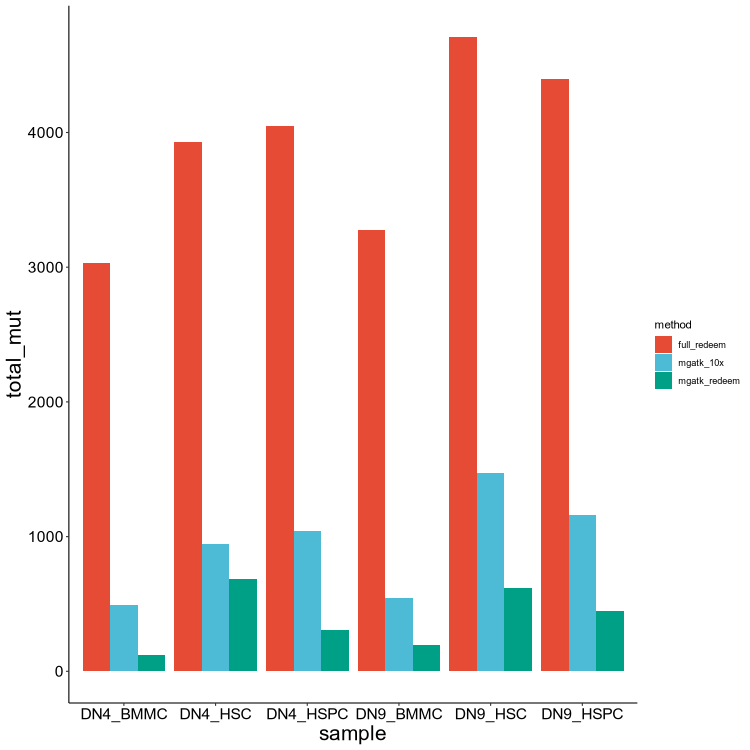

In [48]:
options(repr.plot.width = 10, repr.plot.height = 10, repr.plot.res = 75)
subset(total_mut_count_datatoplot_3methods, age=="young") %>% ggplot()+aes(sample,total_mut,fill=method)+geom_bar(stat="identity", position="dodge")+theme_cw1()+scale_fill_npg()


In [52]:
head(cross_method_mut_list_3methods$DN4_BMMC$mgatk_redeem)

[1] "10000_G_A" "10001_T_C" "10009_G_A" "10010_T_C" "10013_C_A" "10014_G_A"

In [50]:
## Compare mut calls across methods using venn diagram
library(BioVenn)
sample_vennlis <- list()
for(cur_sample in names(cross_method_mut_list_3methods)){
    sample_vennlis[[cur_sample]] <- draw.venn(full_redeem = cross_method_mut_list_3methods[[cur_sample]]$full_redeem,
              mgatk_10x = cross_method_mut_list_3methods[[cur_sample]]$mgatk_10x,
              mgatk_redeem = cross_method_mut_list_3methods[[cur_sample]]$mgatk_redeem,
              nrtype="abs")
}
